In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

import wide_resnet_submodule.config as cf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

In [2]:
ABC_5 = {'Alice':   {'Alice': 0.5,  'Bob': 0.25, 'Charlie': 0.25},
         'Bob':     {'Alice': 0.25, 'Bob': 0.5,  'Charlie': 0.25},
         'Charlie': {'Alice': 0.25, 'Bob': 0.25, 'Charlie': 0.5}}

In [3]:
ABC_9 = {'Alice':   {'Alice': .9,   'Bob': 0.05, 'Charlie': 0.05},
         'Bob':     {'Alice': 0.05, 'Bob': .9,   'Charlie': 0.05},
         'Charlie': {'Alice': 0.05, 'Bob': 0.05, 'Charlie': .9}}

In [4]:
CYCLE4_5 = {'North': {'North': 0.5, 'East':  0.25, 'West':  0.25},
            'East':  {'East':  0.5, 'North': 0.25, 'South': 0.25},
            'South': {'South': 0.5, 'East':  0.25, 'West':  0.25},
            'West':  {'West':  0.5, 'South': 0.25, 'North': 0.25}}

In [5]:
FULL4_52 = {'North': {'North': 0.52, 'East':  0.16, 'West':  0.16, 'South': 0.16},
            'East':  {'East':  0.52, 'North': 0.16, 'South': 0.16, 'West':  0.16},
            'South': {'South': 0.52, 'East':  0.16, 'West':  0.16, 'North': 0.16},
            'West':  {'West':  0.52, 'South': 0.16, 'North': 0.16, 'East':  0.16}}

In [6]:
LONELY = {'Model': {'Model': 1.0}}

In [7]:
topology = ABC_9
n_agents = len(topology)

In [8]:
model_name = 'lenet'
num_classes = 10

if model_name == 'ann':
    input_dim = 28*28
    hidden_dim = 150 
    model_args = [input_dim, hidden_dim, num_classes]
elif model_name == 'lenet':
    model_args = [num_classes]
elif model_name == 'vggnet':
    model_args = [11, num_classes] # depth
elif model_name == 'resnet':
    model_args = [18, num_classes] # depth
elif model_name == 'wide-resnet':
    model_args = [16, 10, 0.3, num_classes] # depth, widen_factor, dropout
else:
    print('Error : Network should be either [Ann / LeNet / VGGNet / ResNet / Wide_ResNet')
    exit(0)

criterion = nn.CrossEntropyLoss
learning_rate = 0.02

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}

In [9]:
# Hyper Parameter settings
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

In [10]:
dataset_name = 'cifar10'  # 'digits' or 'cifar10'

In [11]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    sizes = [len(trainset) // n_agents for i in range(n_agents)]
    sizes[-1] += len(trainset) % n_agents
    subsets = torch.utils.data.random_split(trainset, sizes)
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
elif dataset_name == 'digits':
    train = pd.read_csv(r"../data/digits/train.csv", dtype = np.float32)

    # split data into features(pixels) and labels(numbers from 0 to 9)
    targets_numpy = train.label.values
    features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

    # train test split. Size of train data is 80% and size of test data is 20%. 
    features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                                 targets_numpy,
                                                                                 test_size = 0.2,
                                                                                 random_state = 42)
    train_loaders = {}
    for token, features, targets in zip(topology,
                                        np.array_split(features_train, n_agents),
                                        np.array_split(targets_train, n_agents)):
        featuresTrain = torch.from_numpy(features)
        targetsTrain = torch.from_numpy(targets).type(torch.LongTensor)

        train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
        train_loaders[token] = train_loader
    featuresTest = torch.from_numpy(features_test)
    targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

    test = torch.utils.data.TensorDataset(featuresTest, targetsTest)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [12]:
num_epochs = 10

In [13]:
epoch_len = min(len(tl) for tl in train_loaders.values())
print(epoch_len)

131


In [14]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    model=model_name, # ann / lenet / vggnet / resnet / wide-resnet
                    model_args=model_args, # arguments for model(*model_args)
                    optimizer=optimizer, # SGD or smth like that
                    optimizer_kwargs=optimizer_kwargs, # arguments for optimizer(**optimizer_kwargs)
                    error=criterion, # loss function
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    stat_step=100, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    epoch_cons_num=3 # the first epoch from which consensus begins
                   )

In [15]:
# init consensus nodes
master.initialize_nodes()

In [16]:
#master.network['Alice'].model
# for pretty outputs
# import warnings
# warnings.simplefilter(action='ignore', category=Warning)

In [17]:
master.start_consensus()
print('Done!')

Epoch: 1, Step: 100, Node Alice: accuracy 10.01, loss 229.92
Epoch: 1, Step: 100, Node Bob: accuracy 11.51, loss 229.93
Epoch: 1, Step: 100, Node Charlie: accuracy 14.53, loss 229.68
Epoch: 2, Step: 200, Node Alice: accuracy 15.10, loss 227.06
Epoch: 2, Step: 200, Node Bob: accuracy 20.71, loss 227.04
Epoch: 2, Step: 200, Node Charlie: accuracy 20.71, loss 225.19
Epoch: 3, Step: 300, Node Alice: accuracy 10.08, loss 224.19
Epoch: 3, Step: 300, Node Bob: accuracy 10.06, loss 221.66
Epoch: 3, Step: 300, Node Charlie: accuracy 10.11, loss 218.32
Epoch: 4, Step: 400, Node Alice: accuracy 12.90, loss 229.15
Epoch: 4, Step: 400, Node Bob: accuracy 13.47, loss 229.19
Epoch: 4, Step: 400, Node Charlie: accuracy 12.68, loss 229.17
Epoch: 4, Step: 500, Node Alice: accuracy 19.67, loss 225.50
Epoch: 4, Step: 500, Node Bob: accuracy 19.40, loss 225.53
Epoch: 4, Step: 500, Node Charlie: accuracy 20.79, loss 225.59
Epoch: 5, Step: 600, Node Alice: accuracy 23.39, loss 217.43
Epoch: 5, Step: 600, Nod

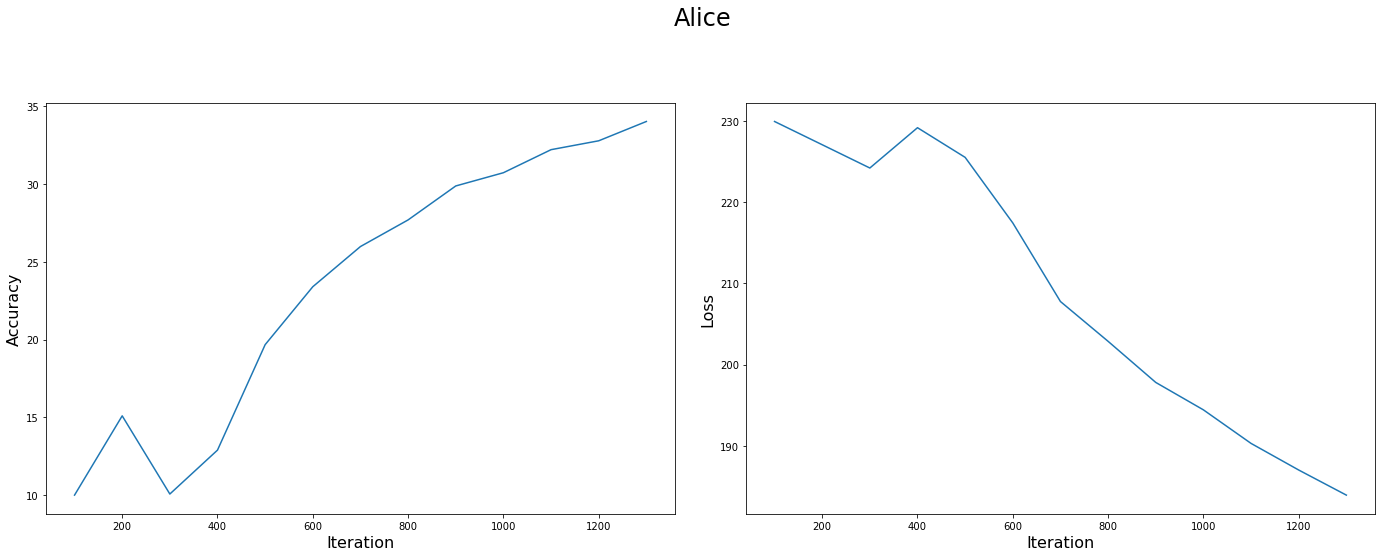

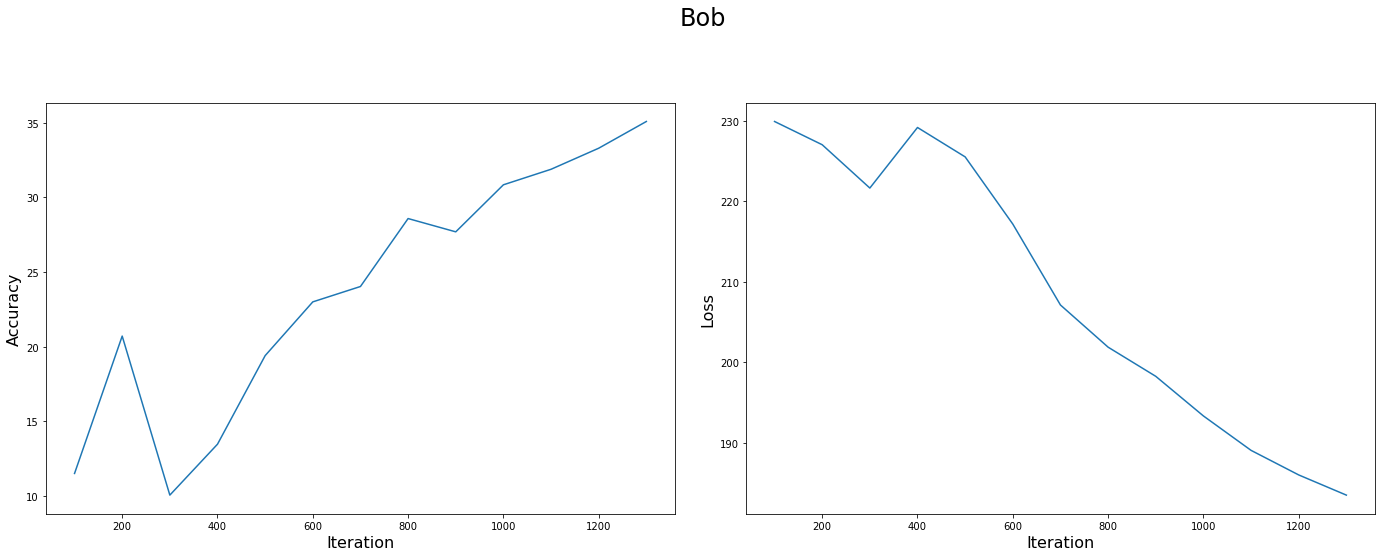

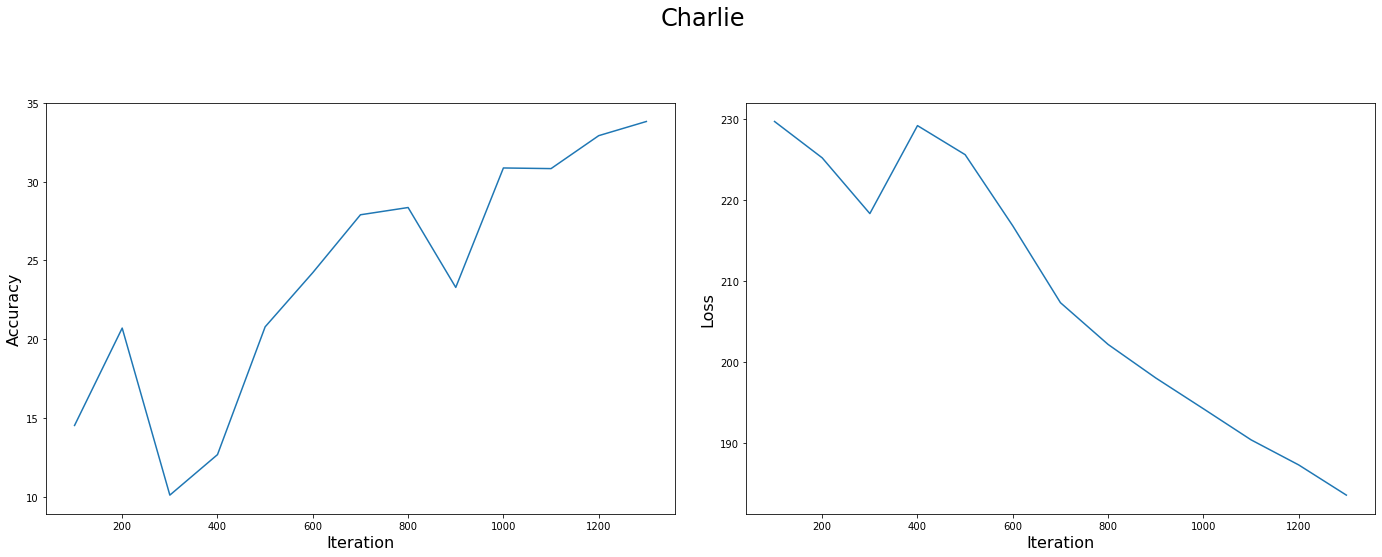

In [18]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()